
# Cassava Leaf Disease Detection


## Using Image Recognition to identify Disease

### Lynn Anderson


# Overview

The objective of this project was to use time series analysis to build a model that accurately predict future real estate values in San Jose, CA. Cassava roots are an important source of calories and nutrition for many people, especially in
sub-Saharan Africa. As the human population increases, it is increasingly important to prioritize
crop health, as fertile land is finite and precious. Identifying diseased plants and appropriately
treating them in a timely manner is important to ensure adequate yields. In this project, I will
train and develop an algorithm that, when given images of Cassava leaves, can accurately
classify that plant as healthy or belonging to a diseased plant. 
# Business Understanding

An agricultural company specializing in treating plant diseases is seeking to improve their effiency and accuracy in identifying diseased plants cassava plants. It is important they can accurately identify plants in need of treatment and determine the best solutions for their customers. 


# Data 

The data for this project was sourced  from the Tensorflow Cassava dataset -
https://www.tensorflow.org/datasets/catalog/cassava
The data consists of leaf images for the cassava plant depicting healthy and four disease
conditions- Cassava Mosaic Disease (CMD), Cassava Bacterial Blight (CBB), Cassava Greem
Mite (CGM), and Cassava Brown Streak Disease (CBSD). There are a total of 9,430 labeled
images, split into a training set (5,656 images), a test set (1,885 images) and a validation set
(1,889 images). The data consists of two folders- a training folder that in turn contains 5
subfolders for the respective images for the different 5 classes, and a test folder containing
validation and test images.

The number of images per class are unbalanced, with the two disease classes CMD and CBSD
having 72% of the images. Dealing with this will require some experimenting and manipulation. for example, I might need to generate additional training data, or train the algorithm to only
identify “diseased” vs normal plants.
The primary modeling techniques to be investigated will be those based on neural networks,
particularly, I anticipate, Multi Layer Perceptrons (MLPs) and Convolutional Neural Networks
(CNNs). The target variable is categorical, with 5 possible categories- normal or belonging to
one of the 4 diseases. Some essential libraries used include Tensorflow, Keras, Pandas,
and Numpy. A basic neural network will be the baseline model, with accuracy of the test data
used to determine model performance. I investigated models with different numbers of hidden
layers, different regularization techniques, and early stopping. I also looked at pre-trained
networks and see if models based on those are higher performing.




# Data Preparation

In [1]:
# run if needed 
#pip install tensorflow-datasets
#pip install tensorflow
#pip install scikeras

In [2]:
#pip install keras

In [3]:
#pip install lime

In [4]:
#pip install jupyter-resource-usage

In [5]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from keras import layers
from keras import models
from keras import regularizers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

from scikeras.wrappers import KerasClassifier, KerasRegressor
import tensorflow.keras as keras
import PIL.Image as Image
import lime

#import tensorflow_addons as tfa
#import tensorflow_datasets as tdfs

### Function to visualize model performance

In [6]:
def visualize_training_results(results):
    history = results.history
    plt.figure(figsize=(6, 4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(6, 4))
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


### preview files

In [7]:
os.listdir('./data')

['cassava-disease.zip',
 'extraimages.zip',
 'random.txt',
 'sample_submission_file.csv',
 'test',
 'test.zip',
 'train',
 'train.zip']

#### unzip the file

In [8]:
from zipfile import ZipFile
  
# loading the temp.zip and creating a zip object
with ZipFile("data/cassava-disease.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path='./data')

#### unzip test folder

In [9]:
with ZipFile("data/test.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path='./data')

#### unzip train folder

In [10]:
with ZipFile("data/train.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path='./data')

#### preview files

In [11]:
print(os.listdir("./data"))

['cassava-disease.zip', 'extraimages.zip', 'random.txt', 'sample_submission_file.csv', 'test', 'test.zip', 'train', 'train.zip']


### preview image file names

In [12]:
import os
Id = []
for dirname, _, filenames in os.walk('./data/train'):
    for filename in filenames:
        Id.append(os.path.join(dirname, filename))
Id[:5]

['./data/train\\cbb\\train-cbb-0.jpg',
 './data/train\\cbb\\train-cbb-1.jpg',
 './data/train\\cbb\\train-cbb-10.jpg',
 './data/train\\cbb\\train-cbb-100.jpg',
 './data/train\\cbb\\train-cbb-101.jpg']

### Make into dataframe

In [13]:
train=pd.DataFrame()
train=train.assign(filename=Id)
train.head()

,filename
0,./data/train\cbb\train-cbb-0.jpg
1,./data/train\cbb\train-cbb-1.jpg
2,./data/train\cbb\train-cbb-10.jpg
3,./data/train\cbb\train-cbb-100.jpg
4,./data/train\cbb\train-cbb-101.jpg


In [14]:
import os
Id_test = []
for dirname, _, filenames in os.walk('./data/test'):
    for filename in filenames:
        Id_test.append(os.path.join(dirname, filename))
Id_test[:5]

['./data/test\\0\\test-img-0.jpg',
 './data/test\\0\\test-img-1.jpg',
 './data/test\\0\\test-img-10.jpg',
 './data/test\\0\\test-img-100.jpg',
 './data/test\\0\\test-img-1000.jpg']

### preview train folder

In [15]:
print(os.listdir("./data/train"))
print(np.shape(os.listdir("./data/train")))

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']
(5,)


In [16]:
print(os.listdir("./data/train/healthy"))
print(np.shape(os.listdir("./data/train/healthy")))

['train-healthy-0.jpg', 'train-healthy-1.jpg', 'train-healthy-10.jpg', 'train-healthy-100.jpg', 'train-healthy-101.jpg', 'train-healthy-102.jpg', 'train-healthy-103.jpg', 'train-healthy-104.jpg', 'train-healthy-105.jpg', 'train-healthy-106.jpg', 'train-healthy-107.jpg', 'train-healthy-108.jpg', 'train-healthy-109.jpg', 'train-healthy-11.jpg', 'train-healthy-110.jpg', 'train-healthy-111.jpg', 'train-healthy-112.jpg', 'train-healthy-113.jpg', 'train-healthy-114.jpg', 'train-healthy-115.jpg', 'train-healthy-116.jpg', 'train-healthy-117.jpg', 'train-healthy-118.jpg', 'train-healthy-119.jpg', 'train-healthy-12.jpg', 'train-healthy-120.jpg', 'train-healthy-121.jpg', 'train-healthy-122.jpg', 'train-healthy-123.jpg', 'train-healthy-124.jpg', 'train-healthy-125.jpg', 'train-healthy-126.jpg', 'train-healthy-127.jpg', 'train-healthy-128.jpg', 'train-healthy-129.jpg', 'train-healthy-13.jpg', 'train-healthy-130.jpg', 'train-healthy-131.jpg', 'train-healthy-132.jpg', 'train-healthy-133.jpg', 'train-

In [17]:
print(os.listdir("./data/test"))
print(np.shape(os.listdir("./data/test")))

['0']
(1,)


There are 5 subfolders in the train directory

### Preprocess images

In [18]:
train_data_dir = 'data/train'
test_data_dir = 'data/test'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(64, 64), batch_size=3774)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=5656)

# Create the datasets
train_images, y_train = next(train_generator)
test_images, y_test = next(test_generator)

Found 3774 images belonging to 1 classes.
Found 5656 images belonging to 5 classes.


#### preview image labels

In [19]:
y_train

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [20]:
y_train[17]

array([0., 0., 1., 0., 0.], dtype=float32)

In [21]:
y_test

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

The test data is not labeled. For this project, I will conduct a train test split on the labelled training data.

In [22]:
# preview shape
print(np.shape(train_images))
print(np.shape(y_train))
print(np.shape(test_images))
print(np.shape(y_test))

(5656, 64, 64, 3)
(5656, 5)
(3774, 64, 64, 3)
(3774, 1)


### reshape images

In [23]:
train_img_unrow = train_images.reshape(5656, -1)#.astype(uint8)
test_img_unrow = test_images.reshape(3774, -1)

# Preview the shape of train_img_unrow
print(np.shape(train_img_unrow))
print(np.shape(test_img_unrow))

(5656, 12288)
(3774, 12288)


#### normalize pixel values

In [24]:
train_img_unrow /= 255.
test_img_unrow /= 255.

## train test split

In [25]:
final_train, final_test, train_labels, test_labels= train_test_split(train_img_unrow, y_train, test_size=0.2, random_state=42,shuffle=True)


# Binary labeling

In [26]:
df = pd.DataFrame(y_train)
df

,0,1,2,3,4
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
5651,0.0,1.0,0.0,0.0,0.0
5652,0.0,0.0,0.0,1.0,0.0
5653,0.0,0.0,0.0,1.0,0.0
5654,0.0,1.0,0.0,0.0,0.0


In [27]:
#df.loc[df[4]==0,'class']=1

df

,0,1,2,3,4
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
5651,0.0,1.0,0.0,0.0,0.0
5652,0.0,0.0,0.0,1.0,0.0
5653,0.0,0.0,0.0,1.0,0.0
5654,0.0,1.0,0.0,0.0,0.0


In [28]:
new=df.copy()

new


,0,1,2,3,4
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
5651,0.0,1.0,0.0,0.0,0.0
5652,0.0,0.0,0.0,1.0,0.0
5653,0.0,0.0,0.0,1.0,0.0
5654,0.0,1.0,0.0,0.0,0.0


In [29]:
new.isnull().sum()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [30]:
#df.loc[df.class!=[0, 0, 0, 0, 1],'class']=0
#df.loc[df.class==[0, 0, 0, 0, 1],'class']=1

In [32]:
"""new.loc[new[4]==1,0]=1
new.loc[new[4]==0,0]=0
new.loc[new[4]==1,1]=0
new.loc[new[4]==0,1]=1
new"""

'new.loc[new[4]==1,0]=1\nnew.loc[new[4]==0,0]=0\nnew.loc[new[4]==1,1]=0\nnew.loc[new[4]==0,1]=1\nnew'

In [33]:
new[4]==0

0       True
1       True
2       True
3       True
4       True
        ... 
5651    True
5652    True
5653    True
5654    True
5655    True
Name: 4, Length: 5656, dtype: bool

In [34]:
new.loc[new[4]==1,"Healthy"]=1
new.loc[new[4]==0,"Healthy"]=0
new.loc[new[4]==1,"Diseased"]=0
new.loc[new[4]==0,"Diseased"]=1
new

,0,1,2,3,4,Healthy,Diseased
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
5651,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5652,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5653,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5654,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [35]:
new.drop([0, 1, 2, 3, 4], axis=1, inplace=True)

In [36]:
new.tail(20)

,Healthy,Diseased
5636,1.0,0.0
5637,0.0,1.0
5638,1.0,0.0
5639,0.0,1.0
5640,0.0,1.0
5641,0.0,1.0
5642,0.0,1.0
5643,0.0,1.0
5644,0.0,1.0
5645,1.0,0.0


# Modeling

# *** Run all above******************

## img class w MLPs

In [47]:
final_train, final_test, train_labels, test_labels= train_test_split(train_img_unrow, y_train, test_size=0.2, random_state=42,shuffle=True)


### basic network

In [24]:
#instantiate model
np.random.seed(42)
model_1 = models.Sequential()
model_1.add(layers.Dense(256, activation='tanh', input_shape=(12288,)))
model_1.add(layers.Dense(5, activation='softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])


In [25]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3145984   
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 3147269 (12.01 MB)
Trainable params: 3147269 (12.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
results_1 = model_1.fit(final_train, 
                        train_labels,
                        epochs=10,
                        batch_size=12,
                        validation_data=(final_test, test_labels))


Epoch 1/10


377/377 [==============================] - 10s 21ms/step - loss: 1.4188 - acc: 0.4452 - val_loss: 1.4725 - val_acc: 0.4806
Epoch 2/10
377/377 [==============================] - 7s 19ms/step - loss: 1.3583 - acc: 0.4534 - val_loss: 1.3990 - val_acc: 0.3604
Epoch 3/10
377/377 [==============================] - 7s 19ms/step - loss: 1.3296 - acc: 0.4607 - val_loss: 1.4103 - val_acc: 0.4859
Epoch 4/10
377/377 [==============================] - 7s 19ms/step - loss: 1.2976 - acc: 0.4794 - val_loss: 1.2927 - val_acc: 0.4885
Epoch 5/10
377/377 [==============================] - 7s 19ms/step - loss: 1.2651 - acc: 0.4903 - val_loss: 1.3643 - val_acc: 0.3728
Epoch 6/10
377/377 [==============================] - 7s 19ms/step - loss: 1.2394 - acc: 0.5011 - val_loss: 1.5055 - val_acc: 0.3534
Epoch 7/10
377/377 [==============================] - 7s 19ms/step - loss: 1.2091 - acc: 0.5133 - val_loss: 1.3366 - val_acc: 0.5124
Epoch 8/10
377/377 [==============================] - 7s 19ms/step

With a training accuracy of 48.5% and testing accuracy of 47%, there is lots of room for improvement. 

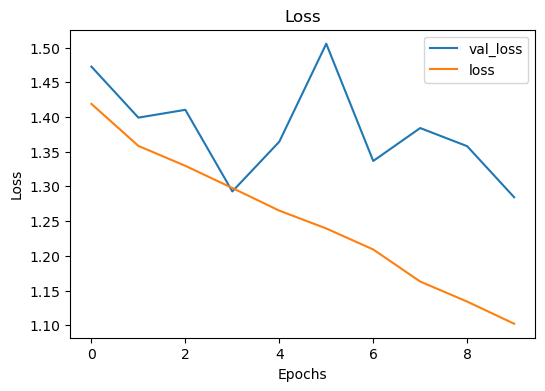

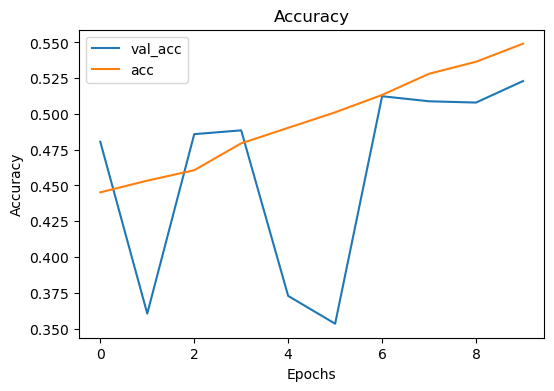

In [27]:
visualize_training_results(results_1)

comments.....

## Network with 1 hidden layer

In [28]:
np.random.seed(42)
model_2 = models.Sequential()
model_2.add(layers.Dense(256, activation='relu', input_shape=(12288,))) 
model_2.add(layers.Dense(32, activation='relu'))
model_2.add(layers.Dense(5, activation='sigmoid'))
model_2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

results_2 = model_2.fit(final_train,
                    train_labels,
                    epochs=10,
                    batch_size=12,
                    validation_data=(final_test, test_labels))

Epoch 1/10
377/377 [==============================] - 10s 24ms/step - loss: 0.4404 - acc: 0.4653 - val_loss: 0.4289 - val_acc: 0.4806
Epoch 2/10
377/377 [==============================] - 7s 19ms/step - loss: 0.4289 - acc: 0.4735 - val_loss: 0.4319 - val_acc: 0.4770
Epoch 3/10
377/377 [==============================] - 7s 18ms/step - loss: 0.4237 - acc: 0.4808 - val_loss: 0.4259 - val_acc: 0.4753
Epoch 4/10
377/377 [==============================] - 8s 20ms/step - loss: 0.4186 - acc: 0.4905 - val_loss: 0.4224 - val_acc: 0.4850
Epoch 5/10
377/377 [==============================] - 8s 21ms/step - loss: 0.4127 - acc: 0.4973 - val_loss: 0.4181 - val_acc: 0.4859
Epoch 6/10
377/377 [==============================] - 8s 20ms/step - loss: 0.4072 - acc: 0.5104 - val_loss: 0.4160 - val_acc: 0.4912
Epoch 7/10
377/377 [==============================] - 8s 21ms/step - loss: 0.4022 - acc: 0.5179 - val_loss: 0.4210 - val_acc: 0.4859
Epoch 8/10
377/377 [==============================] - 8s 21ms/step -

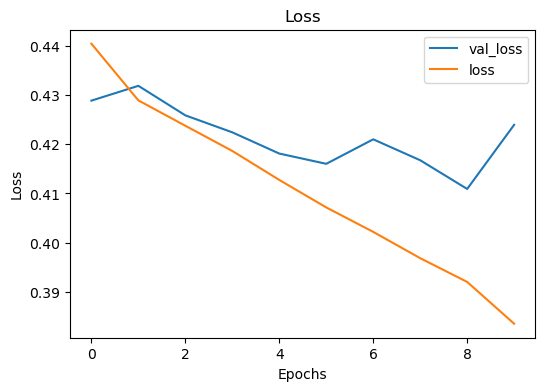

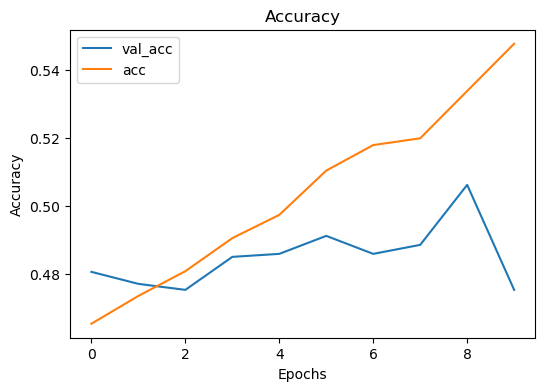

In [29]:
visualize_training_results(results_2)

comments - after 10 eopochs.....

## Network model with 2 hidden layers

In [30]:
np.random.seed(42)
model_3 = models.Sequential()
model_3.add(layers.Dense(256, activation='relu', input_shape=(12288,))) 
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dense(16, activation='relu'))
model_3.add(layers.Dense(5, activation='sigmoid'))
model_3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

results_3 = model_3.fit(final_train,
                    train_labels,
                    epochs=10,
                    batch_size=12,
                    validation_data=(final_test, test_labels))

Epoch 1/10
377/377 [==============================] - 9s 21ms/step - loss: 0.4459 - acc: 0.4547 - val_loss: 0.4301 - val_acc: 0.4806
Epoch 2/10
377/377 [==============================] - 7s 19ms/step - loss: 0.4316 - acc: 0.4697 - val_loss: 0.4303 - val_acc: 0.4806
Epoch 3/10
377/377 [==============================] - 7s 19ms/step - loss: 0.4267 - acc: 0.4757 - val_loss: 0.4262 - val_acc: 0.4885
Epoch 4/10
377/377 [==============================] - 8s 20ms/step - loss: 0.4231 - acc: 0.4839 - val_loss: 0.4216 - val_acc: 0.4850
Epoch 5/10
377/377 [==============================] - 7s 19ms/step - loss: 0.4189 - acc: 0.4847 - val_loss: 0.4222 - val_acc: 0.4859
Epoch 6/10
377/377 [==============================] - 7s 19ms/step - loss: 0.4148 - acc: 0.4973 - val_loss: 0.4158 - val_acc: 0.4859
Epoch 7/10
377/377 [==============================] - 7s 19ms/step - loss: 0.4105 - acc: 0.5077 - val_loss: 0.4186 - val_acc: 0.4920
Epoch 8/10
377/377 [==============================] - 8s 20ms/step - 

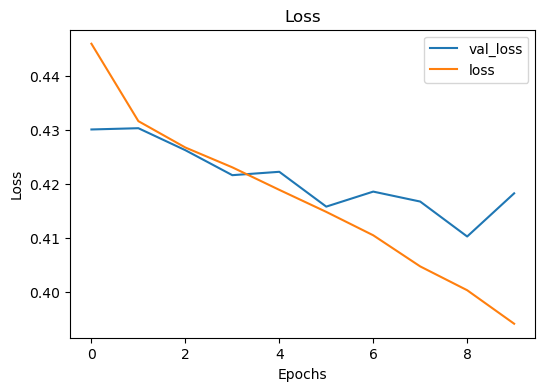

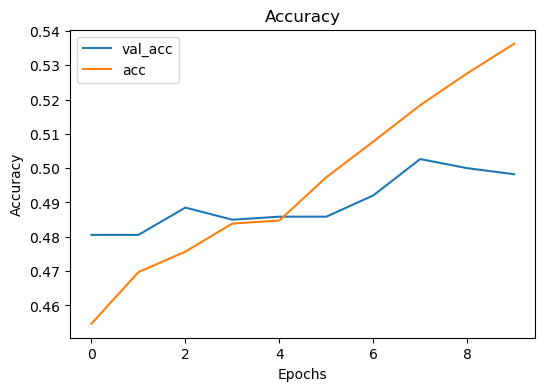

In [31]:
visualize_training_results(results_3)

comments - after 10 eopochs.....

### grid search to find best params

In [32]:
def buildModel(optimizer):
    # Initialising the ANN
    classifier = models.Sequential()
    
    # Adding the input layer and the first hidden layer
    classifier.add(layers.Dense(128, activation = 'relu'))
    
    # Adding the second hidden layer
    classifier.add(layers.Dense(32, activation='relu'))
        
    # Adding the output layer
    classifier.add(layers.Dense(5, activation='sigmoid'))
    
    # Compiling the ANN
    classifier.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])
    
    return classifier



In [33]:
classifier = KerasRegressor(build_fn = buildModel)
#What hyperparameter we want to play with
parameters = {'batch_size': [16, 32, 64, 128],
              'epochs': [10, 50, 100],
              'optimizer': ['adam', 'sgd' 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'neg_mean_absolute_error',
                           cv = 5)
grid_search = grid_search.fit(final_train, train_labels, verbose = 0)

C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-pa

C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-pa

C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-pa

C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-pa

TypeError: buildModel() missing 1 required positional argument: 'optimizer'

In [35]:
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: " + str(best_parameters))

Best Parameters: {'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}


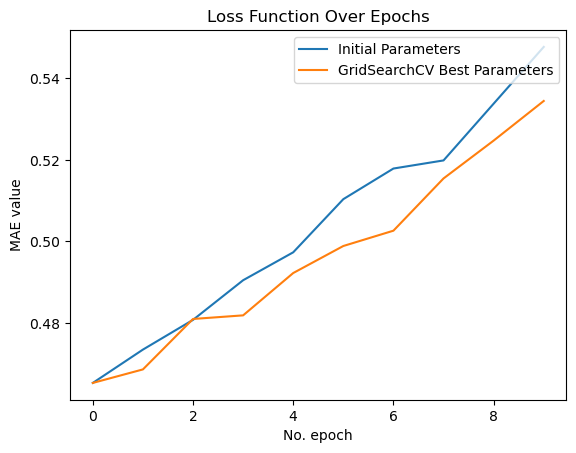

In [36]:
bestClassifier = buildModel('adam')
HistoryBest = bestClassifier.fit(final_train, train_labels, batch_size = 16, epochs =10 , verbose = 0)
plt.plot(results_2.history['acc'], label='Initial Parameters')
plt.plot(HistoryBest.history['acc'], label='GridSearchCV Best Parameters')
plt.title('Loss Function Over Epochs')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

## L2 reg.

In [71]:
# Import regularizers
from keras import regularizers

np.random.seed(42)

L2_model = models.Sequential()

# Add the input and first hidden layer
L2_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(12288,)))

# Add another hidden layer
L2_model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

# Add an output layer
L2_model.add(layers.Dense(5, activation='softmax'))

# Compile the model
L2_model.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['acc'])

# Train the model 
L2_model_results = L2_model.fit(final_train, 
                            train_labels, 
                            epochs=10, 
                            batch_size=16, 
                            validation_data=(final_test, test_labels))

Epoch 1/10
283/283 [==============================] - 12s 37ms/step - loss: 2.4872 - acc: 0.4200 - val_loss: 2.0608 - val_acc: 0.4682
Epoch 2/10
283/283 [==============================] - 9s 32ms/step - loss: 1.6920 - acc: 0.4582 - val_loss: 1.5230 - val_acc: 0.5124
Epoch 3/10
283/283 [==============================] - 9s 33ms/step - loss: 1.5044 - acc: 0.4898 - val_loss: 1.5411 - val_acc: 0.4823
Epoch 4/10
283/283 [==============================] - 10s 35ms/step - loss: 1.4498 - acc: 0.4825 - val_loss: 1.5243 - val_acc: 0.3719
Epoch 5/10
283/283 [==============================] - 10s 34ms/step - loss: 1.4058 - acc: 0.4898 - val_loss: 1.5019 - val_acc: 0.4664
Epoch 6/10
283/283 [==============================] - 9s 33ms/step - loss: 1.3833 - acc: 0.4912 - val_loss: 1.4189 - val_acc: 0.4841
Epoch 7/10
283/283 [==============================] - 9s 33ms/step - loss: 1.3662 - acc: 0.4991 - val_loss: 1.4272 - val_acc: 0.4735
Epoch 8/10
283/283 [==============================] - 10s 34ms/ste

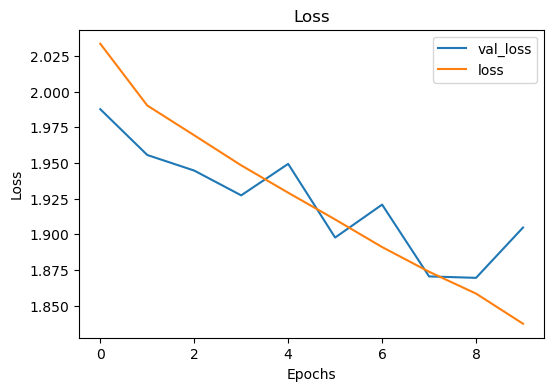

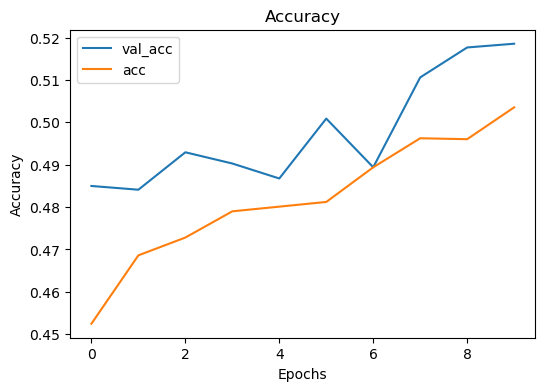

In [39]:
visualize_training_results(L2_model_results)

## L1 reg

In [72]:
np.random.seed(42)

L1_model = models.Sequential()

# Add the input and first hidden layer
L1_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.005), input_shape=(12288,)))

# Add a hidden layer
L1_model.add(layers.Dense(32, kernel_regularizer=regularizers.l1(0.005), activation='relu'))

# Add an output layer
L1_model.add(layers.Dense(5, activation='softmax'))

# Compile the model
L1_model.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['acc'])

# Train the model 
L1_model_val = L1_model.fit(final_train, 
                            train_labels,
                            epochs=10, 
                            batch_size=16, 
                            validation_data=(final_test, test_labels))

Epoch 1/10
283/283 [==============================] - 14s 41ms/step - loss: 9.6220 - acc: 0.4149 - val_loss: 3.2647 - val_acc: 0.4664
Epoch 2/10
283/283 [==============================] - 11s 39ms/step - loss: 3.0617 - acc: 0.4587 - val_loss: 2.7732 - val_acc: 0.4664
Epoch 3/10
283/283 [==============================] - 10s 36ms/step - loss: 2.6548 - acc: 0.4708 - val_loss: 2.5025 - val_acc: 0.4664
Epoch 4/10
283/283 [==============================] - 12s 41ms/step - loss: 2.4371 - acc: 0.4699 - val_loss: 2.3575 - val_acc: 0.4664
Epoch 5/10
283/283 [==============================] - 11s 39ms/step - loss: 2.3173 - acc: 0.4708 - val_loss: 2.2772 - val_acc: 0.4664
Epoch 6/10
283/283 [==============================] - 11s 39ms/step - loss: 2.2459 - acc: 0.4708 - val_loss: 2.2176 - val_acc: 0.4664
Epoch 7/10
283/283 [==============================] - 12s 43ms/step - loss: 2.2154 - acc: 0.4708 - val_loss: 2.2103 - val_acc: 0.4664
Epoch 8/10
283/283 [==============================] - 12s 42ms

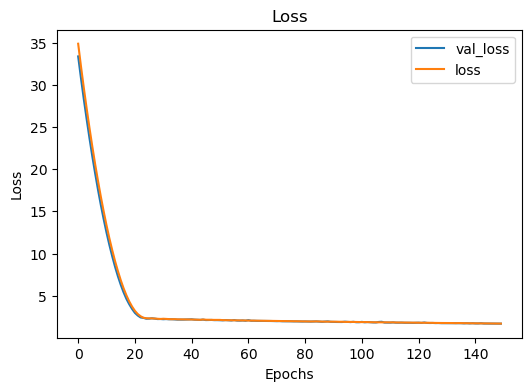

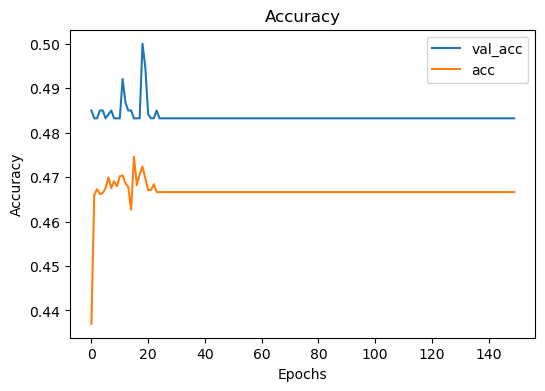

In [57]:
visualize_training_results(L1_model_val)

## dropout reg

In [73]:
np.random.seed(42)
dropout_model = models.Sequential()

# Implement dropout to the input layer
# NOTE: This is where you define the number of units in the input layer
dropout_model.add(layers.Dropout(0.3, input_shape=(12288,)))

# Add the first hidden layer
dropout_model.add(layers.Dense(128, activation='relu'))

# Implement dropout to the first hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the second hidden layer
dropout_model.add(layers.Dense(32, activation='relu'))

# Implement dropout to the second hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the output layer
dropout_model.add(layers.Dense(5, activation='softmax'))


# Compile the model
dropout_model.compile(optimizer='adam', 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])

# Train the model
dropout_model_val = dropout_model.fit(final_train, 
                                      train_labels,
                                      epochs=10, 
                                      batch_size=16, 
                                      validation_data=(final_test, test_labels))

Epoch 1/10
283/283 [==============================] - 13s 37ms/step - loss: 1.6156 - acc: 0.4005 - val_loss: 1.3800 - val_acc: 0.4664
Epoch 2/10
283/283 [==============================] - 10s 34ms/step - loss: 1.4029 - acc: 0.4565 - val_loss: 1.3805 - val_acc: 0.4664
Epoch 3/10
283/283 [==============================] - 10s 34ms/step - loss: 1.3571 - acc: 0.4708 - val_loss: 1.3494 - val_acc: 0.4664
Epoch 4/10
283/283 [==============================] - 10s 34ms/step - loss: 1.3524 - acc: 0.4708 - val_loss: 1.3481 - val_acc: 0.4664
Epoch 5/10
283/283 [==============================] - 9s 33ms/step - loss: 1.3472 - acc: 0.4708 - val_loss: 1.3477 - val_acc: 0.4664
Epoch 6/10
283/283 [==============================] - 10s 34ms/step - loss: 1.3464 - acc: 0.4708 - val_loss: 1.3479 - val_acc: 0.4664
Epoch 7/10
283/283 [==============================] - 10s 34ms/step - loss: 1.3490 - acc: 0.4708 - val_loss: 1.3479 - val_acc: 0.4664
Epoch 8/10
283/283 [==============================] - 10s 37ms/

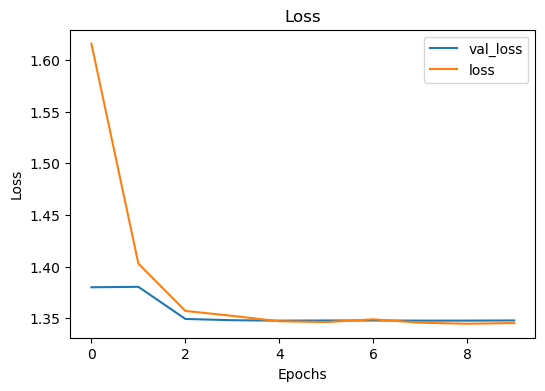

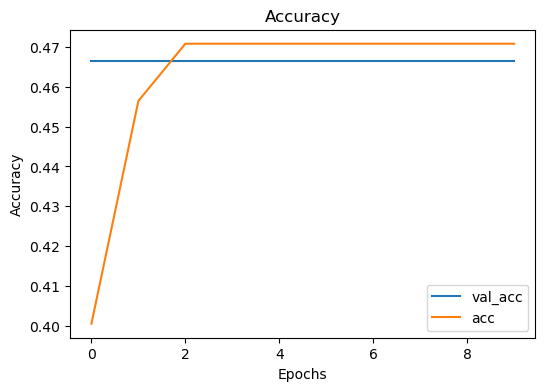

In [74]:
visualize_training_results(dropout_model_val)


## CNN model

# Resume here**************************

In [56]:
cnn_train, cnn_test, cnn_train_labels, cnn_test_labels= train_test_split(train_images, y_train, test_size=0.2, random_state=42,shuffle=True)


In [57]:
np.random.seed(42)
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64, 64, 3))) 
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(5, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])
cnn_results = cnn_model.fit(cnn_train,
                            cnn_train_labels, 
                            epochs=10,
                            batch_size=16,
                            validation_data=(cnn_test, cnn_test_labels))

Epoch 1/10
283/283 [==============================] - 21s 63ms/step - loss: 0.4209 - acc: 0.5097 - val_loss: 0.3841 - val_acc: 0.5601
Epoch 2/10
283/283 [==============================] - 17s 60ms/step - loss: 0.3771 - acc: 0.5844 - val_loss: 0.3638 - val_acc: 0.6016
Epoch 3/10
283/283 [==============================] - 17s 59ms/step - loss: 0.3588 - acc: 0.6105 - val_loss: 0.3444 - val_acc: 0.6343
Epoch 4/10
283/283 [==============================] - 16s 58ms/step - loss: 0.3494 - acc: 0.6176 - val_loss: 0.3619 - val_acc: 0.6148
Epoch 5/10
283/283 [==============================] - 17s 60ms/step - loss: 0.3369 - acc: 0.6355 - val_loss: 0.3351 - val_acc: 0.6360
Epoch 6/10
283/283 [==============================] - 17s 58ms/step - loss: 0.3316 - acc: 0.6408 - val_loss: 0.3425 - val_acc: 0.6219
Epoch 7/10
283/283 [==============================] - 17s 60ms/step - loss: 0.3249 - acc: 0.6430 - val_loss: 0.3560 - val_acc: 0.6025
Epoch 8/10
283/283 [==============================] - 17s 60ms

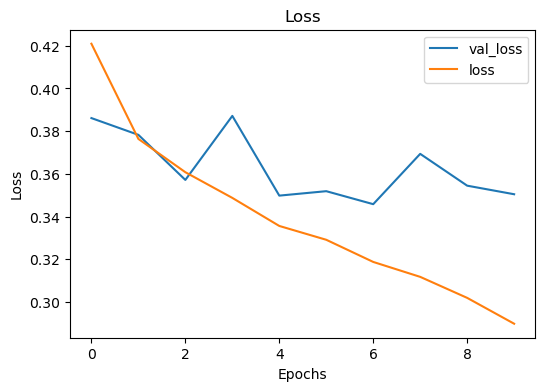

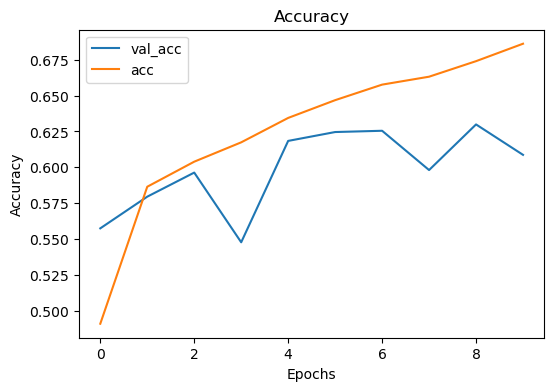

In [50]:
visualize_training_results(cnn_results)

In [52]:
cnn_model.predict(train_images)

177/177 [==============================] - 3s 18ms/step


array([[0.01299931, 0.02219673, 0.1845125 , 0.76847506, 0.00922346],
       [0.00944669, 0.06501047, 0.0391132 , 0.908931  , 0.00227526],
       [0.04058356, 0.20334606, 0.0818547 , 0.5218522 , 0.01492923],
       ...,
       [0.0698426 , 0.9261389 , 0.01644939, 0.02833226, 0.00293856],
       [0.2348979 , 0.07532524, 0.46521398, 0.2801116 , 0.15330409],
       [0.07507371, 0.16329663, 0.10355534, 0.60972774, 0.03597278]],
      dtype=float32)

In [54]:
cnn_model.evaluate(train_images)

177/177 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - acc: 0.0000e+00


[0.0, 0.0]

# Binary classification

# Modeling

# *** Run all above******************

In [217]:
binary_train, binary_test, binary_train_labels, binary_test_labels= train_test_split(train_img_unrow, new, test_size=0.2, random_state=42,shuffle=True)


### basic network binary

In [222]:
#instantiate model
#np.random.seed(42)
binary_model_1 = models.Sequential()
binary_model_1.add(layers.Dense(256, activation='tanh', input_shape=(12288,)))
binary_model_1.add(layers.Dense(2, activation='softmax'))

binary_model_1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])


In [223]:
binary_model_1.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 256)               3145984   
                                                                 
 dense_49 (Dense)            (None, 2)                 514       
                                                                 
Total params: 3146498 (12.00 MB)
Trainable params: 3146498 (12.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [224]:
binary_results_1 = binary_model_1.fit(binary_train, 
                        binary_train_labels,
                        epochs=10,
                        batch_size=12,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/10
377/377 [==============================] - 8s 19ms/step - loss: 0.2413 - acc: 0.9436 - val_loss: 0.2109 - val_acc: 0.9461
Epoch 2/10
377/377 [==============================] - 7s 19ms/step - loss: 0.2207 - acc: 0.9436 - val_loss: 0.2296 - val_acc: 0.9461
Epoch 3/10
377/377 [==============================] - 8s 22ms/step - loss: 0.2165 - acc: 0.9436 - val_loss: 0.2262 - val_acc: 0.9461
Epoch 4/10
377/377 [==============================] - 9s 23ms/step - loss: 0.2138 - acc: 0.9436 - val_loss: 0.2245 - val_acc: 0.9461
Epoch 5/10
377/377 [==============================] - 9s 24ms/step - loss: 0.2112 - acc: 0.9436 - val_loss: 0.2146 - val_acc: 0.9461
Epoch 6/10
377/377 [==============================] - 10s 26ms/step - loss: 0.2064 - acc: 0.9436 - val_loss: 0.2231 - val_acc: 0.9461
Epoch 7/10
377/377 [==============================] - 8s 23ms/step - loss: 0.2059 - acc: 0.9436 - val_loss: 0.2243 - val_acc: 0.9461
Epoch 8/10
377/377 [==============================] - 9s 23ms/step -

With a training accuracy of 48.5% and testing accuracy of 47%, there is lots of room for improvement. 

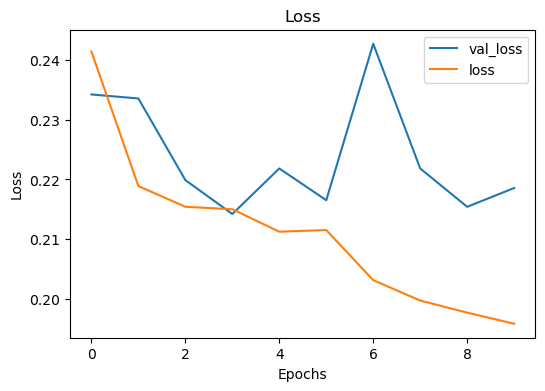

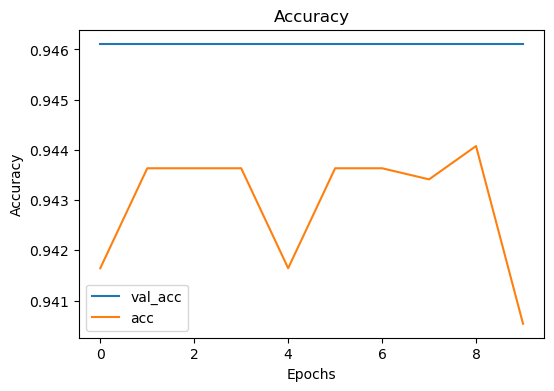

In [221]:
visualize_training_results(binary_results_1)

comments.....

## Network with 1 hidden layer- binary

In [225]:
#np.random.seed(42)
binary_model_2 = models.Sequential()
binary_model_2.add(layers.Dense(256, activation='relu', input_shape=(12288,))) 
binary_model_2.add(layers.Dense(32, activation='relu'))
binary_model_2.add(layers.Dense(2, activation='sigmoid'))
binary_model_2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

binary_results_2 = binary_model_2.fit(binary_train, 
                        binary_train_labels,
                        epochs=10,
                        batch_size=12,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/10
377/377 [==============================] - 9s 21ms/step - loss: 0.2319 - acc: 0.9412 - val_loss: 0.2220 - val_acc: 0.9461
Epoch 2/10
377/377 [==============================] - 8s 20ms/step - loss: 0.2249 - acc: 0.9436 - val_loss: 0.2229 - val_acc: 0.9461
Epoch 3/10
377/377 [==============================] - 7s 19ms/step - loss: 0.2216 - acc: 0.9436 - val_loss: 0.2163 - val_acc: 0.9461
Epoch 4/10
377/377 [==============================] - 7s 20ms/step - loss: 0.2208 - acc: 0.9436 - val_loss: 0.2214 - val_acc: 0.9461
Epoch 5/10
377/377 [==============================] - 8s 20ms/step - loss: 0.2174 - acc: 0.9436 - val_loss: 0.2260 - val_acc: 0.9461
Epoch 6/10
377/377 [==============================] - 7s 19ms/step - loss: 0.2161 - acc: 0.9436 - val_loss: 0.2233 - val_acc: 0.9461
Epoch 7/10
377/377 [==============================] - 7s 19ms/step - loss: 0.2134 - acc: 0.9436 - val_loss: 0.2208 - val_acc: 0.9461
Epoch 8/10
377/377 [==============================] - 8s 20ms/step - 

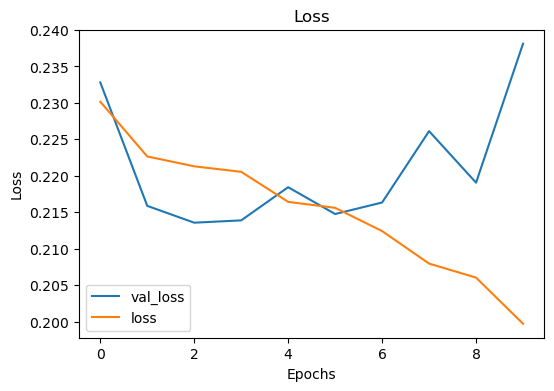

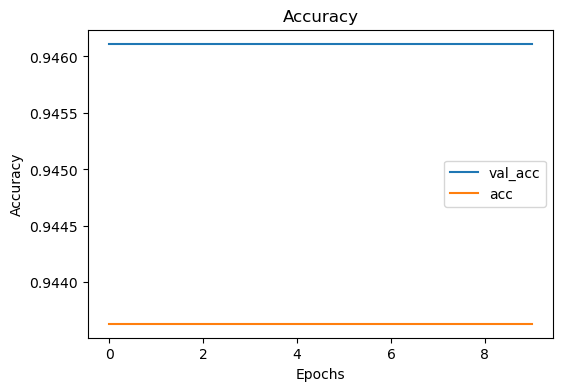

In [181]:
visualize_training_results(binary_results_2)

comments - after 10 eopochs.....

## Network model with 2 hidden layers - binary

In [182]:
np.random.seed(42)
binary_model_3 = models.Sequential()
binary_model_3.add(layers.Dense(256, activation='relu', input_shape=(12288,))) 
binary_model_3.add(layers.Dense(64, activation='relu'))
binary_model_3.add(layers.Dense(16, activation='relu'))
binary_model_3.add(layers.Dense(2, activation='sigmoid'))
binary_model_3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

binary_results_3 = binary_model_3.fit(binary_train, 
                        binary_train_labels,
                        epochs=10,
                        batch_size=12,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/10
377/377 [==============================] - 9s 21ms/step - loss: 0.2356 - acc: 0.9432 - val_loss: 0.2140 - val_acc: 0.9461
Epoch 2/10
377/377 [==============================] - 8s 21ms/step - loss: 0.2232 - acc: 0.9436 - val_loss: 0.2171 - val_acc: 0.9461
Epoch 3/10
377/377 [==============================] - 8s 21ms/step - loss: 0.2221 - acc: 0.9436 - val_loss: 0.2142 - val_acc: 0.9461
Epoch 4/10
377/377 [==============================] - 8s 20ms/step - loss: 0.2200 - acc: 0.9436 - val_loss: 0.2144 - val_acc: 0.9461
Epoch 5/10
377/377 [==============================] - 7s 20ms/step - loss: 0.2175 - acc: 0.9436 - val_loss: 0.2139 - val_acc: 0.9461
Epoch 6/10
377/377 [==============================] - 7s 20ms/step - loss: 0.2173 - acc: 0.9436 - val_loss: 0.2134 - val_acc: 0.9461
Epoch 7/10
377/377 [==============================] - 8s 20ms/step - loss: 0.2135 - acc: 0.9436 - val_loss: 0.2168 - val_acc: 0.9461
Epoch 8/10
377/377 [==============================] - 7s 19ms/step - 

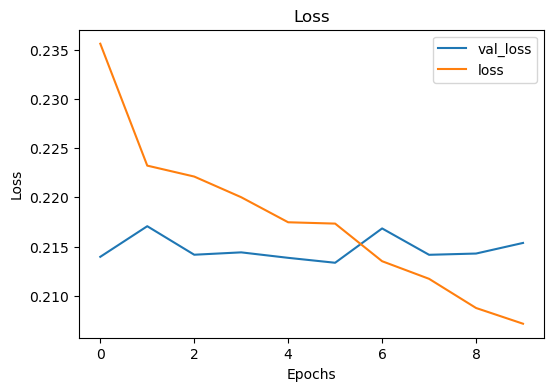

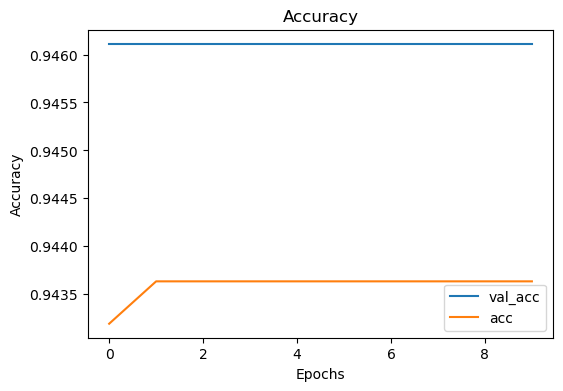

In [183]:
visualize_training_results(binary_results_3)

comments - after 10 eopochs.....

### grid search to find best params in binary model

In [226]:
def buildModel_binary(optimizer):
    # Initialising the ANN
    classifier = models.Sequential()
    
    # Adding the input layer and the first hidden layer
    classifier.add(layers.Dense(128, activation = 'relu'))
    
    # Adding the second hidden layer
    classifier.add(layers.Dense(32, activation='relu'))
        
    # Adding the output layer
    classifier.add(layers.Dense(2, activation='sigmoid'))
    
    # Compiling the ANN
    classifier.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])
    
    return classifier



In [231]:
binary_classifier = KerasRegressor(build_fn = buildModel_binary)
#What hyperparameter we want to play with
parameters = {'batch_size': [16, 32, 64, 128],
              'epochs': [5, 10, 50, 100],
              'optimizer': ['adam', 'sgd' 'rmsprop']}
binary_grid_search = GridSearchCV(estimator = binary_classifier,
                           param_grid = parameters,
                           scoring = 'neg_mean_absolute_error',
                           cv = 5)
binary_grid_search = binary_grid_search.fit(binary_train, binary_train_labels, verbose = 0)

C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-pa

C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-pa

C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-pa

C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-pa

C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-pa

TypeError: buildModel_binary() missing 1 required positional argument: 'optimizer'

In [232]:
binary_best_parameters = binary_grid_search.best_params_
best_score = binary_grid_search.best_score_

print("Best Parameters: " + str(best_parameters))

Best Parameters: {'batch_size': 16, 'epochs': 5, 'optimizer': 'adam'}


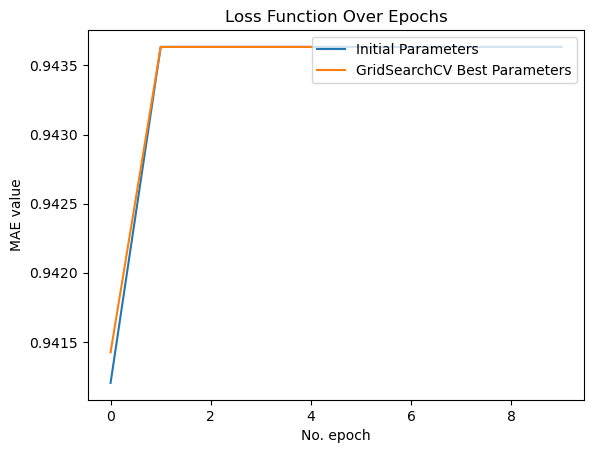

In [234]:
best_binary_Classifier = buildModel_binary('adam')
HistoryBest_binary = best_binary_Classifier.fit(binary_train, binary_train_labels, batch_size = 16, epochs =5 , verbose = 0)
plt.plot(binary_results_2.history['acc'], label='Initial Parameters')
plt.plot(HistoryBest_binary.history['acc'], label='GridSearchCV Best Parameters')
plt.title('Loss Function Over Epochs')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

## L2 reg.

In [194]:
# Import regularizers
from keras import regularizers

np.random.seed(42)

binary_L2_model = models.Sequential()

# Add the input and first hidden layer
binary_L2_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(12288,)))

# Add another hidden layer
binary_L2_model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

# Add an output layer
binary_L2_model.add(layers.Dense(2, activation='softmax'))

# Compile the model
binary_L2_model.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['acc'])

# Train the model 
binary_L2_model_results = binary_L2_model.fit(binary_train, 
                        binary_train_labels,
                        epochs=5,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/5
283/283 [==============================] - 14s 39ms/step - loss: 1.1987 - acc: 0.9330 - val_loss: 0.4929 - val_acc: 0.9461
Epoch 2/5
283/283 [==============================] - 10s 34ms/step - loss: 0.4065 - acc: 0.9436 - val_loss: 0.3389 - val_acc: 0.9461
Epoch 3/5
283/283 [==============================] - 10s 35ms/step - loss: 0.3154 - acc: 0.9436 - val_loss: 0.2791 - val_acc: 0.9461
Epoch 4/5
283/283 [==============================] - 10s 35ms/step - loss: 0.2873 - acc: 0.9436 - val_loss: 0.2638 - val_acc: 0.9461
Epoch 5/5
283/283 [==============================] - 11s 38ms/step - loss: 0.2772 - acc: 0.9436 - val_loss: 0.2672 - val_acc: 0.9461


In [75]:
visualize_training_results(binary_L2_model_results)

NameError: name 'binary_L2_model_results' is not defined

## L1 reg

In [195]:
np.random.seed(42)

binary_L1_model = models.Sequential()

# Add the input and first hidden layer
binary_L1_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.005), input_shape=(12288,)))

# Add a hidden layer
binary_L1_model.add(layers.Dense(32, kernel_regularizer=regularizers.l1(0.005), activation='relu'))

# Add an output layer
binary_L1_model.add(layers.Dense(2, activation='softmax'))

# Compile the model
binary_L1_model.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['acc'])

# Train the model 
binary_L1_model_val = binary_L1_model.fit(binary_train, 
                        binary_train_labels,
                        epochs=5,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/5
283/283 [==============================] - 15s 42ms/step - loss: 7.6588 - acc: 0.9401 - val_loss: 1.6176 - val_acc: 0.9461
Epoch 2/5
283/283 [==============================] - 11s 39ms/step - loss: 1.5232 - acc: 0.9436 - val_loss: 1.4310 - val_acc: 0.9461
Epoch 3/5
283/283 [==============================] - 11s 38ms/step - loss: 1.3023 - acc: 0.9436 - val_loss: 1.3208 - val_acc: 0.9461
Epoch 4/5
283/283 [==============================] - 11s 39ms/step - loss: 1.1901 - acc: 0.9436 - val_loss: 1.1594 - val_acc: 0.9461
Epoch 5/5
283/283 [==============================] - 12s 43ms/step - loss: 1.1325 - acc: 0.9436 - val_loss: 1.1018 - val_acc: 0.9461


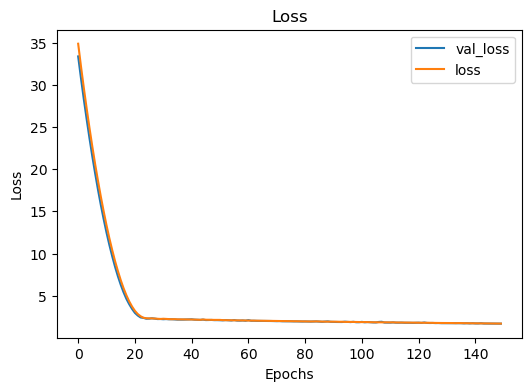

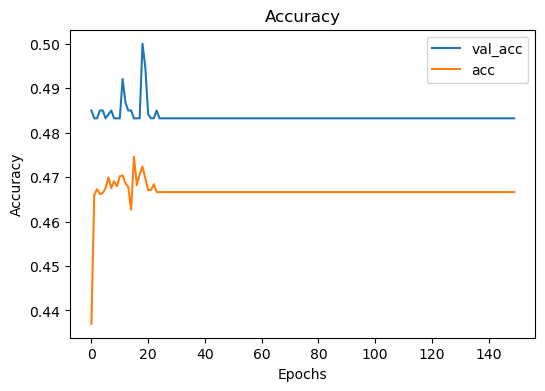

In [57]:
visualize_training_results(binary_L1_model_val)

## dropout reg

In [196]:
np.random.seed(42)
binary_dropout_model = models.Sequential()

# Implement dropout to the input layer
# NOTE: This is where you define the number of units in the input layer
binary_dropout_model.add(layers.Dropout(0.3, input_shape=(12288,)))

# Add the first hidden layer
binary_dropout_model.add(layers.Dense(128, activation='relu'))

# Implement dropout to the first hidden layer 
binary_dropout_model.add(layers.Dropout(0.3))

# Add the second hidden layer
binary_dropout_model.add(layers.Dense(32, activation='relu'))

# Implement dropout to the second hidden layer 
binary_dropout_model.add(layers.Dropout(0.3))

# Add the output layer
binary_dropout_model.add(layers.Dense(2, activation='softmax'))


# Compile the model
binary_dropout_model.compile(optimizer='adam', 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])

# Train the model
binary_dropout_model_val = binary_dropout_model.fit(binary_train, 
                        binary_train_labels,
                        epochs=5,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/5
283/283 [==============================] - 14s 39ms/step - loss: 0.4477 - acc: 0.9184 - val_loss: 0.2335 - val_acc: 0.9461
Epoch 2/5
283/283 [==============================] - 11s 37ms/step - loss: 0.2667 - acc: 0.9410 - val_loss: 0.2233 - val_acc: 0.9461
Epoch 3/5
283/283 [==============================] - 10s 37ms/step - loss: 0.2519 - acc: 0.9436 - val_loss: 0.2250 - val_acc: 0.9461
Epoch 4/5
283/283 [==============================] - 11s 38ms/step - loss: 0.2536 - acc: 0.9436 - val_loss: 0.2107 - val_acc: 0.9461
Epoch 5/5
283/283 [==============================] - 11s 40ms/step - loss: 0.2308 - acc: 0.9436 - val_loss: 0.2131 - val_acc: 0.9461


In [39]:
visualize_training_results(binary_dropout_model_val)

NameError: name 'binary_dropout_model_val' is not defined


## CNN model

# Resume here**************************

In [37]:
cnn_binary_train, cnn_binary_test, cnn_binary_train_labels, cnn_binary_test_labels= train_test_split(train_images, new, test_size=0.2, random_state=42,shuffle=True)


In [38]:
np.random.seed(42)
binary_cnn_model = models.Sequential()
binary_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64, 64, 3))) 
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Flatten())
binary_cnn_model.add(layers.Dense(64, activation='relu'))
binary_cnn_model.add(layers.Dense(2, activation='sigmoid'))

binary_cnn_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])
binary_cnn_results = binary_cnn_model.fit(cnn_binary_train,
                            cnn_binary_train_labels,
                            epochs=5,
                            batch_size=16,
                            validation_data=(cnn_binary_test, cnn_binary_test_labels))




Epoch 1/5


283/283 [==============================] - 21s 63ms/step - loss: 0.2359 - acc: 0.9381 - val_loss: 0.1766 - val_acc: 0.9558
Epoch 2/5
283/283 [==============================] - 17s 60ms/step - loss: 0.2223 - acc: 0.9412 - val_loss: 0.1850 - val_acc: 0.9558
Epoch 3/5
283/283 [==============================] - 17s 60ms/step - loss: 0.2168 - acc: 0.9412 - val_loss: 0.1837 - val_acc: 0.9558
Epoch 4/5
283/283 [==============================] - 18s 65ms/step - loss: 0.2136 - acc: 0.9412 - val_loss: 0.1716 - val_acc: 0.9558
Epoch 5/5
283/283 [==============================] - 18s 65ms/step - loss: 0.2129 - acc: 0.9412 - val_loss: 0.1669 - val_acc: 0.9558


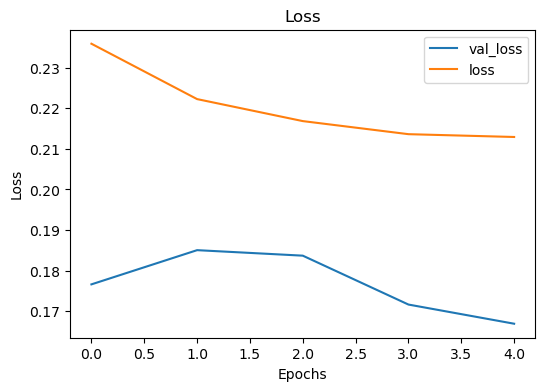

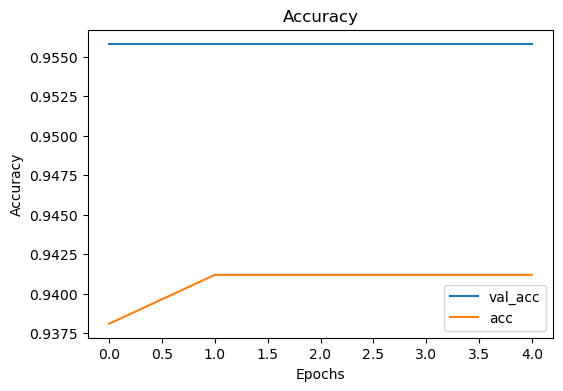

In [40]:
visualize_training_results(binary_cnn_results)

In [41]:
binary_cnn_model.predict(cnn_binary_train)

142/142 [==============================] - 4s 29ms/step


array([[0.04607533, 0.95416397],
       [0.05073219, 0.9479766 ],
       [0.05085381, 0.9469376 ],
       ...,
       [0.07346795, 0.92406535],
       [0.0275506 , 0.97158164],
       [0.0885951 , 0.9092826 ]], dtype=float32)

In [243]:
binary_cnn_model.evaluate(cnn_binary_train)

142/142 [==============================] - 1s 4ms/step - loss: 0.0000e+00 - acc: 0.0000e+00


[0.0, 0.0]

## Early stopping tuning-neural-networks-with-regularization-lab

In [ ]:
# Import EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
#train
model = model.fit(final_train, 
                          train_labels,
                          epochs=10, 
                          callbacks=early_stopping, 
                          batch_size=16, 
                          validation_data=(final_test, test_labels))
# eval
results = saved_model.evaluate(X_train_tokens, y_train_lb)


# LIME
https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb 

In [43]:
from keras.applications.imagenet_utils import decode_predictions
preds = cnn_model.predict(train_images)
print(preds[0:15])

177/177 [==============================] - 5s 28ms/step
[[5.9135440e-03 9.9439341e-01]
 [3.7662294e-02 9.5924532e-01]
 [8.3983272e-02 9.1501886e-01]
 [3.2005288e-02 9.6548671e-01]
 [4.2047478e-02 9.5785964e-01]
 [3.6402311e-02 9.6356839e-01]
 [2.3011500e-02 9.7665572e-01]
 [7.0993356e-02 9.2657787e-01]
 [5.9806723e-02 9.3758667e-01]
 [6.7659811e-04 9.9921525e-01]
 [1.5262397e-03 9.9838257e-01]
 [6.5549050e-04 9.9933511e-01]
 [1.9588258e-02 9.7950810e-01]
 [8.7181352e-02 9.1120934e-01]
 [7.0215389e-02 9.2357749e-01]]


In [44]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [45]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(train_images[0].astype('double'), cnn_model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step
Wall time: 21.8 s


In [46]:
from skimage.segmentation import mark_boundaries

#### see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

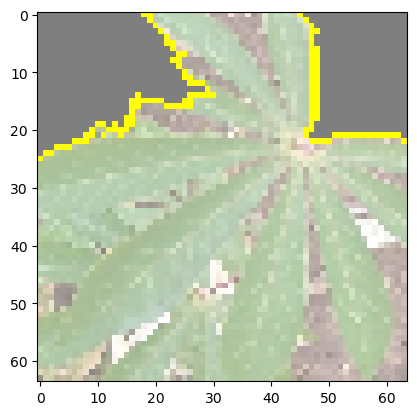

In [40]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#### Or with the rest of the image present:

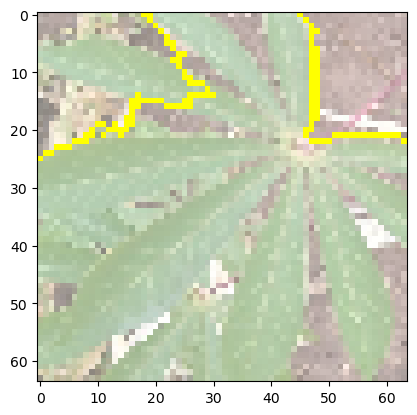

In [41]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#### see the 'pros and cons' (pros in green, cons in red)

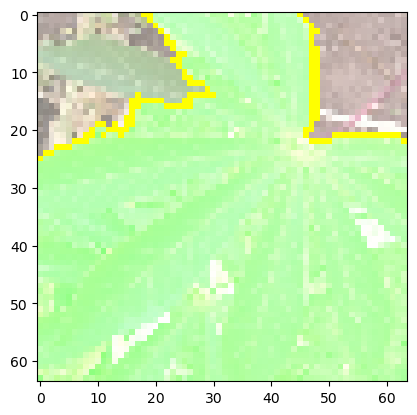

In [42]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#### plot explanation weights onto a heatmap visualization. The colorbar shows the values of the weights.

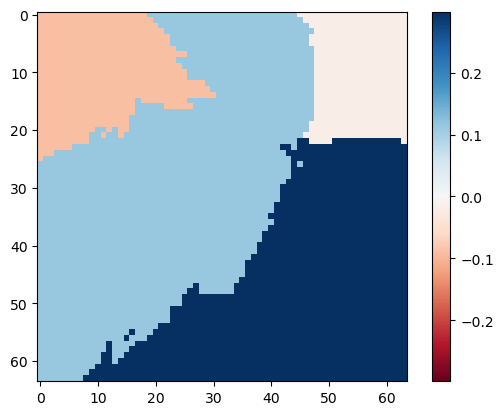

In [43]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

## Tuning models- pipeline stuff- keras wrapper?

In [7]:
def create_baseline_model():
    
    # Initialize model
    model = models.Sequential()

    # First hidden layer
    model.add(layers.Dense(10, activation='relu', input_shape=(n_features,)))

    # Second hidden layer
    model.add(layers.Dense(5, activation='relu'))

    # Output layer
    model.add(layers.Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer='SGD', 
                  loss='mse',  
                  metrics=['mse']) 
    
    # Return the compiled model
    return model

In [8]:
keras_wrapper_1 = KerasRegressor(create_baseline_model,  
                                 epochs=150, 
                                 batch_size=256, 
                                 verbose=0)

C:\Users\lalyn\AppData\Local\Temp\ipykernel_15024\293714094.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_wrapper_1 = KerasRegressor(create_baseline_model,


# Visualization

### intermediate activation functions

### display img

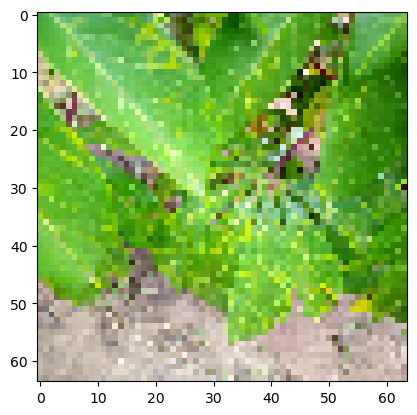

In [53]:
plt.imshow(train_images[0])
plt.show()




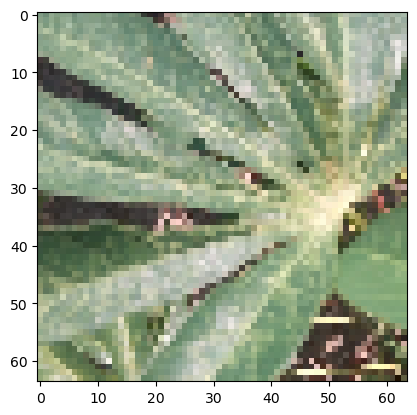

In [54]:

plt.imshow(test_images[0])
plt.show()


## visualize layers

In [58]:
layer_outputs = [layer.output for layer in cnn_model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=cnn_model.input, outputs=layer_outputs)

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        16416     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 64)         

### View third channel of first activation layer

177/177 [==============================] - 29s 164ms/step
(5656, 62, 62, 32)


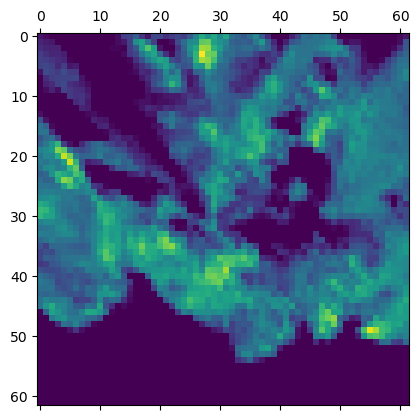

In [59]:
# Returns an array for each activation layer
activations = activation_model.predict(train_images)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

## channel 30 of first activation layer

In [60]:
# Repeating the process for another channel (the 30th)
activations = activation_model.predict(train_images)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')
plt.show()

177/177 [==============================] - 28s 157ms/step


MemoryError: Unable to allocate 2.59 GiB for an array with shape (5656, 62, 62, 32) and data type float32

## view channel i of first activation layer

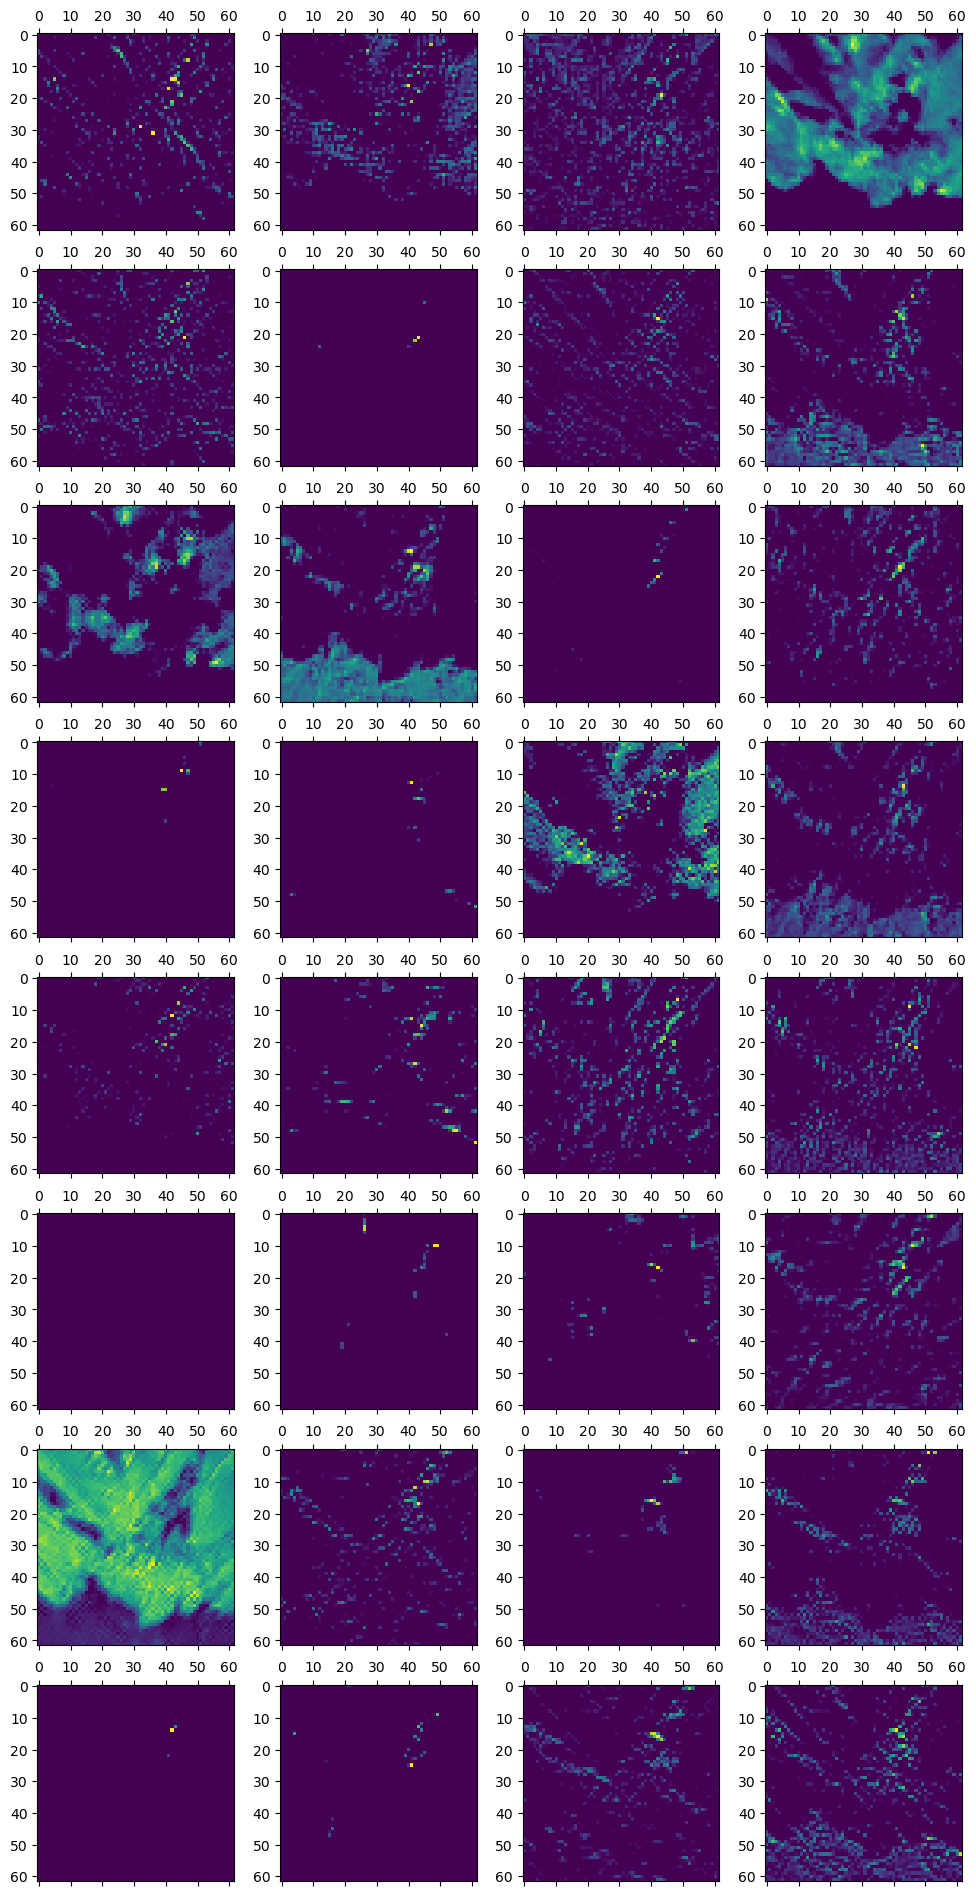

In [61]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

### View channel 29 for all activation layers

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

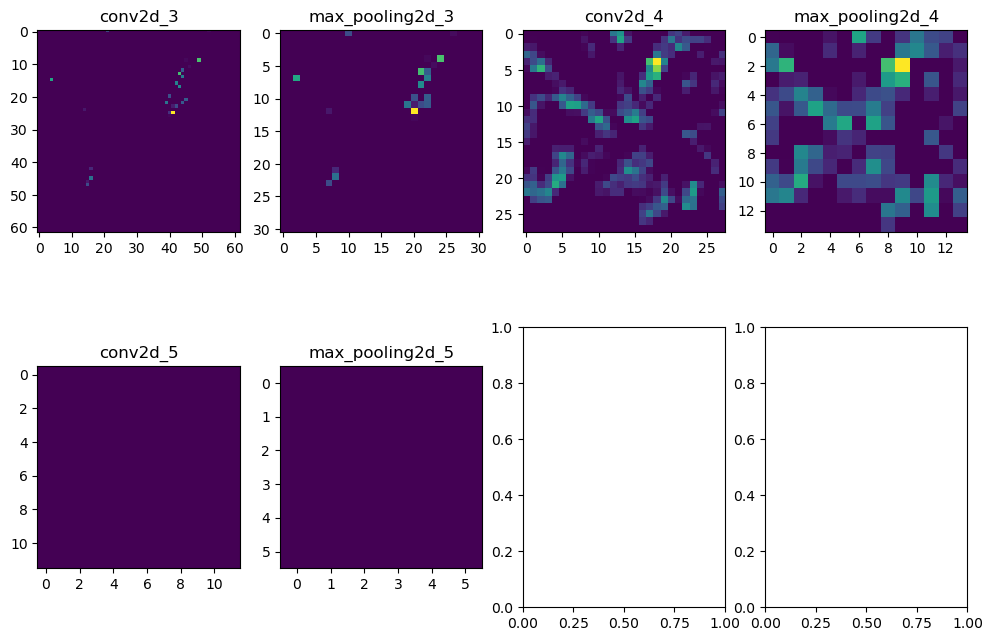

In [63]:
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in cnn_model.layers[:8]:
    layer_names.append(layer.name)

for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 29], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

### visualize activation layers  lab - plot feature maps for each channel of all the layers

In [67]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in cnn_model.layers[:8]]

# Create a model for displaying the feature maps
activation_model = models.Model(inputs=cnn_model.input, outputs=layer_outputs)

activations = activation_model.predict(train_images)

# Extract Layer Names for Labelling
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

total_features = sum([a.shape[-1] for a in activations])
total_features

n_cols = 16
n_rows = math.ceil(total_features / n_cols)


iteration = 0
fig , axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols, n_rows*1.5))

for layer_n, layer_activation in enumerate(activations):
    n_channels = layer_activation.shape[-1]
    for ch_idx in range(n_channels):
        row = iteration // n_cols
        column = iteration % n_cols
    
        ax = axes[row, column]

        channel_image = layer_activation[0,
                                         :, :,
                                         ch_idx]
        # Post-process the feature to make it visually palatable
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std() 
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        ax.imshow(channel_image, aspect='auto', cmap='viridis')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        if ch_idx == 0:
            ax.set_title(layer_names[layer_n], fontsize=10)
        iteration += 1

fig.subplots_adjust(hspace=1.25)
plt.savefig('Intermediate_Activations_Visualized.pdf')
plt.show()

177/177 [==============================] - 63s 354ms/step


MemoryError: Unable to allocate 2.59 GiB for an array with shape (5656, 62, 62, 32) and data type float32

# LIME for binary 
https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb 

In [68]:
from keras.applications.imagenet_utils import decode_predictions
preds1 = binary_cnn_model.predict(train_images)
print(preds1[0:15])

177/177 [==============================] - 4s 20ms/step
[[5.9135440e-03 9.9439341e-01]
 [3.7662294e-02 9.5924532e-01]
 [8.3983272e-02 9.1501886e-01]
 [3.2005288e-02 9.6548671e-01]
 [4.2047478e-02 9.5785964e-01]
 [3.6402311e-02 9.6356839e-01]
 [2.3011500e-02 9.7665572e-01]
 [7.0993356e-02 9.2657787e-01]
 [5.9806723e-02 9.3758667e-01]
 [6.7659811e-04 9.9921525e-01]
 [1.5262397e-03 9.9838257e-01]
 [6.5549050e-04 9.9933511e-01]
 [1.9588258e-02 9.7950810e-01]
 [8.7181352e-02 9.1120934e-01]
 [7.0215389e-02 9.2357749e-01]]


In [37]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [69]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(train_images[10].astype('double'), binary_cnn_model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step
Wall time: 15.4 s


In [70]:
from skimage.segmentation import mark_boundaries

#### see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

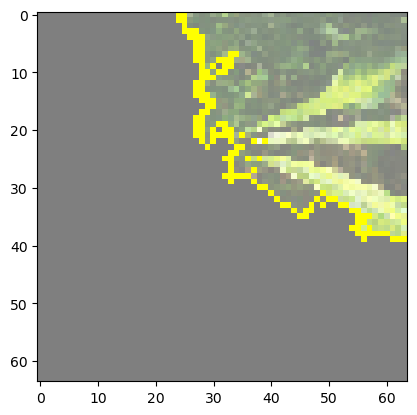

In [71]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#### Or with the rest of the image present:

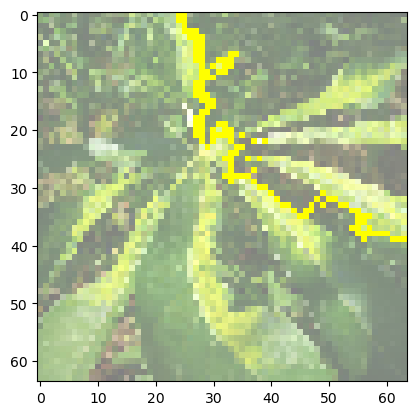

In [72]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#### see the 'pros and cons' (pros in green, cons in red)

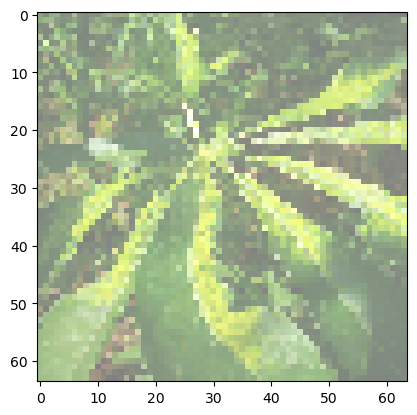

In [73]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#### plot explanation weights onto a heatmap visualization. The colorbar shows the values of the weights.

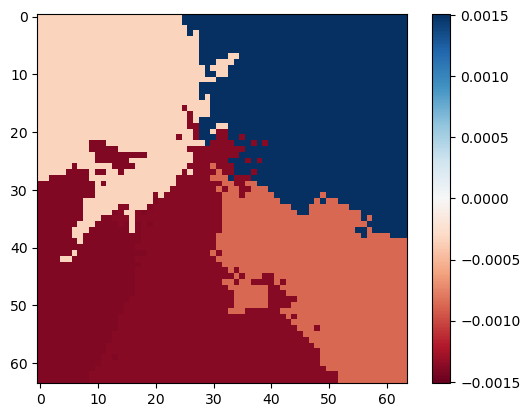

In [74]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()